/home/newhouse/.local/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator


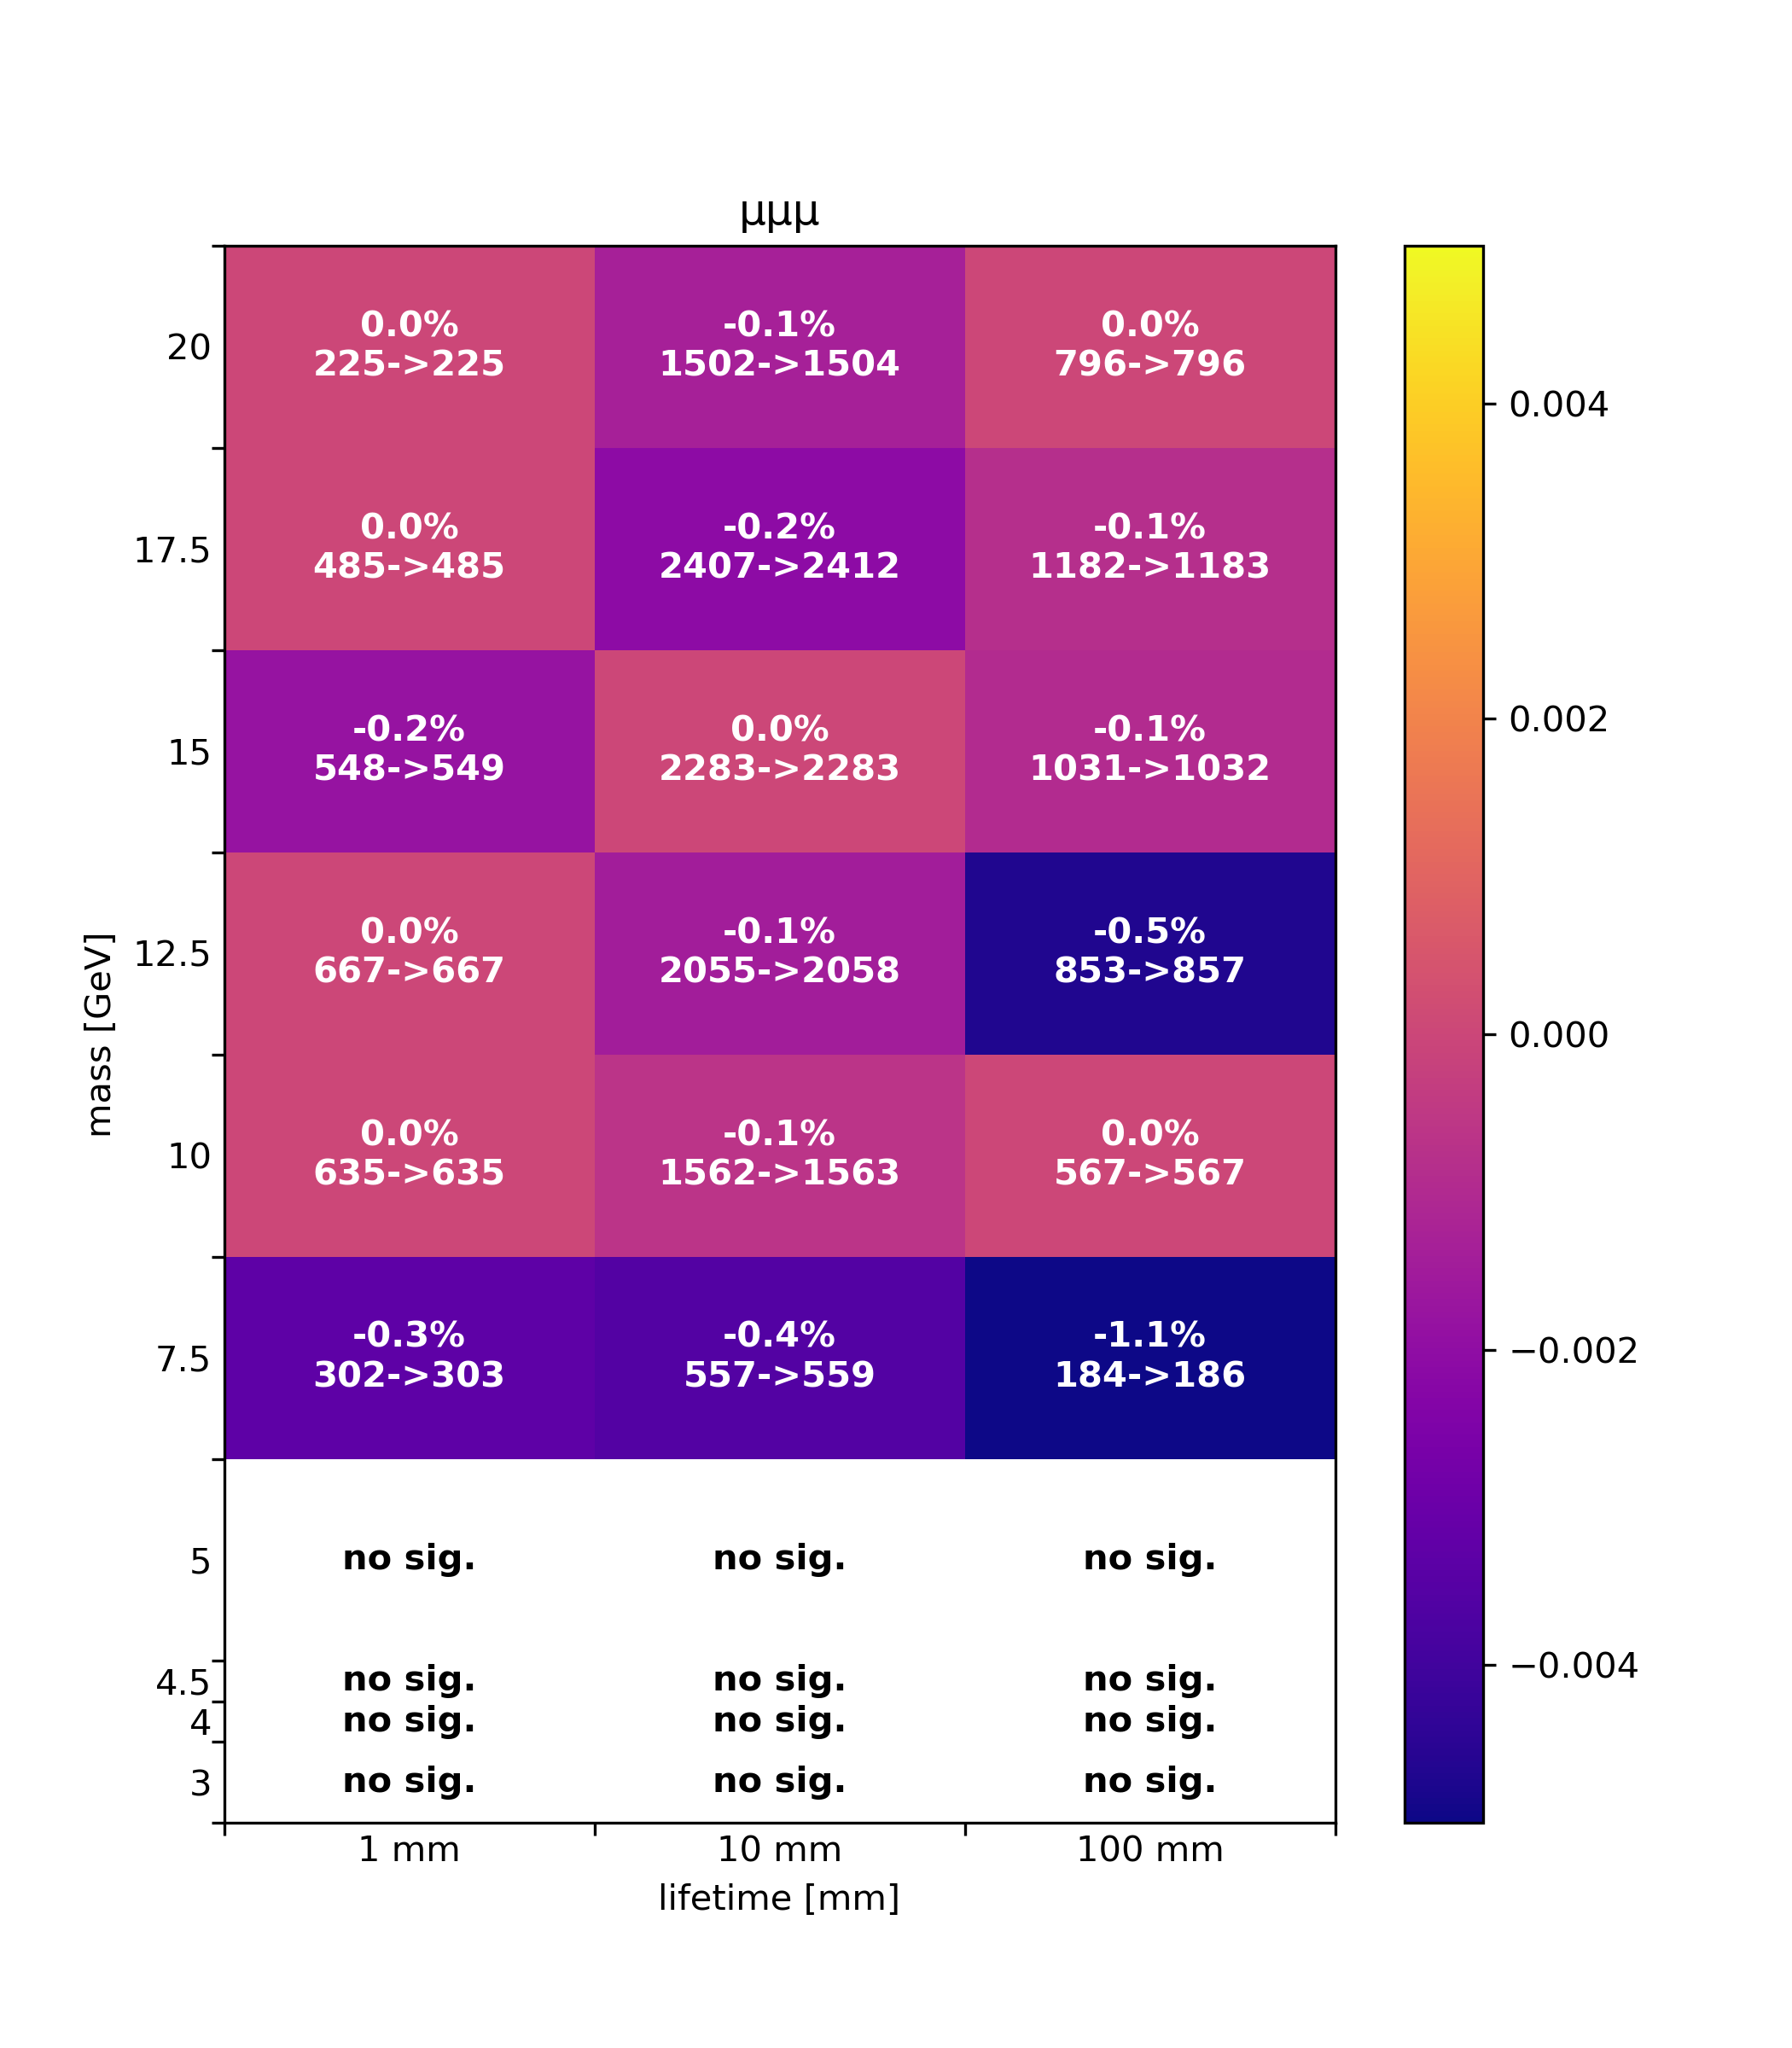

/home/newhouse/.local/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator


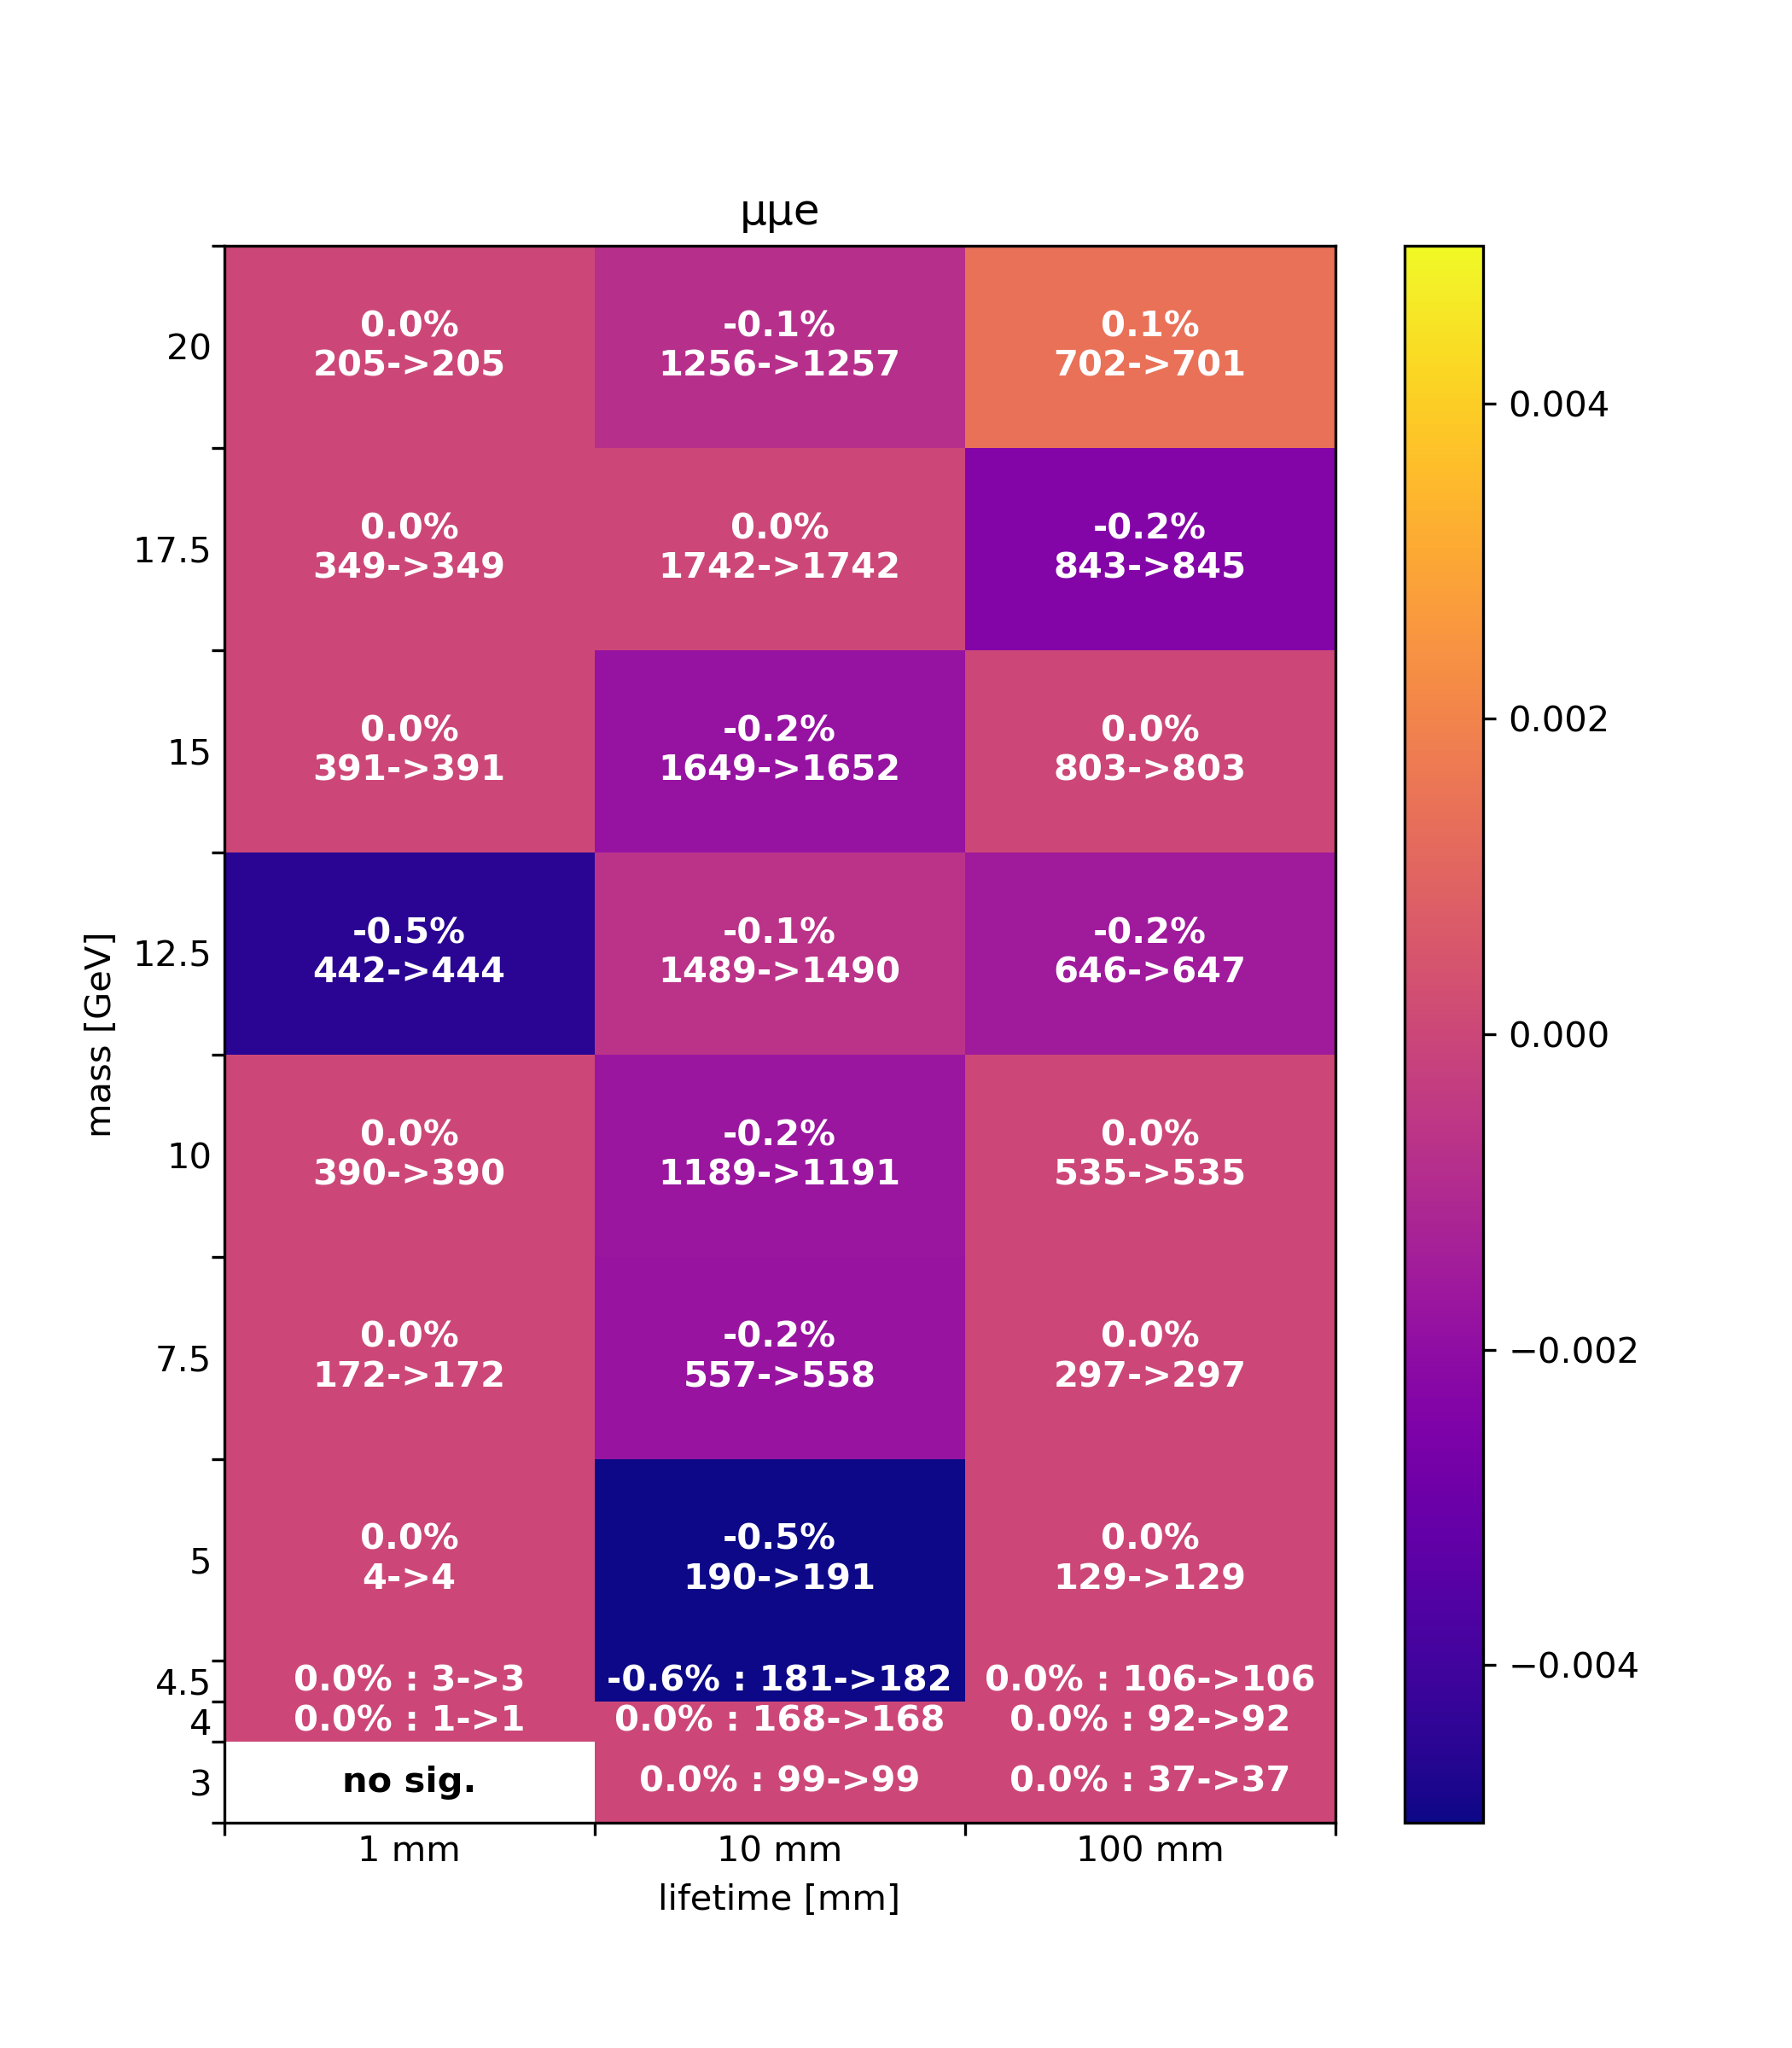

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/newhouse/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-36623b35ce71>", line 121, in <module>
    make_uncertainty_plot(histpath='histograms_fullrun2_*_eeu.root', title='eeμ', outfile='compare_eeu')
  File "<ipython-input-2-36623b35ce71>", line 39, in make_uncertainty_plot
    f_fullrun2_v6 = uproot.open(hist_file.replace(indir_1, indir_2))
  File "/home/newhouse/miniconda3/lib/python3.7/site-packages/uproot/rootio.py", line 55, in open
    return ROOTDirectory.read(openfcn(path), **options)
  File "/home/newhouse/miniconda3/lib/python3.7/site-packages/uproot/rootio.py", line 123, in read
    magic, fVersion = cursor.fields(source, ROOTDirectory._format1)
  File "/home/newhouse/miniconda3/lib/python3.7/site

TypeError: object of type 'NoneType' has no len()

In [2]:
import uproot
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image


masses = [3, 4, 4.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5]
lifetimes = {1:0, 10:1, 100:2}

def set_bin_content(mass, lifetime, value, arr):
    ybin = np.max(np.digitize(mass, masses)-1, 0)
    xbin = lifetimes[lifetime]
    arr[ybin,xbin] = value

def make_uncertainty_plot(histpath, title, outfile):

    count_arr = np.array([
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    ])

    count_arr_1 = np.array(count_arr)
    count_arr_2 = np.array(count_arr)
    diff_arr = np.array(count_arr)

    # get bins from ntuples    
    for hist_file in glob.glob(f'{indir_1}{histpath}'):
        f_fullrun2_1 = uproot.open(hist_file)
        f_fullrun2_2 = uproot.open(hist_file.replace(indir_1, indir_2))
        count_1 = -100
        count_2 = -100
        try:
            # count_1 = len(f_fullrun2_1['VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']['HNLm'])
            count_1 = f_fullrun2_1['VSI_LeptonsMod/CutFlow/CutFlow_weighted_LNC'].pandas()[1:-1].iloc[-3]['count']

        except:
            pass
        try:
            # count_2 = len(f_fullrun2_2['VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']['HNLm'])
            count_2 = f_fullrun2_2['VSI_LeptonsMod/CutFlow/CutFlow_weighted_LNC'].pandas()[1:-1].iloc[-3]['count']
        except:
            pass

        tokens = hist_file.split('histograms_fullrun2_')[1].split('_')
        file_mass = float(tokens[0][:-1].replace('p','.'))
        file_lifetime = int(tokens[1].split('mm')[0])

        set_bin_content(file_mass, file_lifetime, count_1, count_arr_1)
        set_bin_content(file_mass, file_lifetime, count_2, count_arr_2)

        diff = np.nan
        if count_2 >= 0:
            diff = (count_2-count_1)/count_2
        set_bin_content(file_mass, file_lifetime, diff, diff_arr)

    # do the plotting
    plot_uncertainties(count_arr_1, count_arr_2, diff_arr, title, outfile)
    return count_arr_1, count_arr_2, diff_arr

def plot_uncertainties(count_arr_1, count_arr_2, diff_arr, title, outfile):
    plt.figure(figsize=[7,8])
    plt.pcolormesh([0,1,2,3], masses, diff_arr, vmin=-.005, vmax=.005, cmap='plasma')
    plt.colorbar()
    ax = plt.gca()

    # mess with x ticks
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels('')
    ax.set_xticklabels(['1 mm', '10 mm', '100 mm',], minor=True)
    ax.set_xticks([0.5,1.5,2.5,], minor=True)
    ax.tick_params(axis='both', which='minor', length=0)

    # mess with y ticks
    ax.set_yticks(masses)
    ax.set_yticklabels('')
    ax.tick_params(which='minor', length=0)
    ax.set_yticks(masses[:-1] + np.diff(masses)/2, minor=True)
    ax.set_yticklabels(masses[:-1], minor=True)

    ax.set_title(title)
    ax.set_xlabel('lifetime [mm]')
    ax.set_ylabel('mass [GeV]')

    # set text
    for i in range(len(masses)-1):
        for j in range(len(lifetimes)):
            yloc = j+.5
            xloc = masses[i] + (masses[i+1]-masses[i])/2
            if not np.isnan(diff_arr[i,j]):
                delim = '\n' if masses[i] >= 5 else ' : '
                text = f'{diff_arr[i,j]:0.1%}{delim}{int(count_arr_2[i,j])}->{int(count_arr_1[i,j])}' 
                ax.text(yloc, xloc , text,
                        ha="center", va="center", color="white", fontweight='bold', transform=ax.transData)
            else:
                text = 'no sig.'
                ax.text(yloc, xloc , text,
                    ha="center", va="center", color="black", fontweight='bold', transform=ax.transData)

    os.makedirs(outdir, exist_ok=True)
    plt.savefig(outdir+outfile+'.png', dpi=300)
    plt.savefig(outdir+outfile+'.pdf', dpi=300)

indir_1 = '/data/hnl/v6_histograms/jun15_mc_1_histograms_new_overlap_def_loose_muons/run2_hists/'
indir_2 = '/data/hnl/v6_histograms/jun15_mc_v6p01_histograms/run2_hists/'
outdir = '/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/ntuple_comparison/plots/'

make_uncertainty_plot(histpath=f'histograms_fullrun2_*_uuu.root', title='μμμ', outfile='compare_uuu')
display(Image(filename=f'{outdir}compare_uuu.png'));

make_uncertainty_plot(histpath='histograms_fullrun2_*_uue.root', title='μμe', outfile='compare_uue')
display(Image(filename=f'{outdir}compare_uue.png'));

make_uncertainty_plot(histpath='histograms_fullrun2_*_eeu.root', title='eeμ', outfile='compare_eeu')
display(Image(filename=f'{outdir}compare_eeu.png'));

make_uncertainty_plot(histpath='histograms_fullrun2_*_eee.root', title='eee', outfile='compare_eee')
display(Image(filename=f'{outdir}compare_eee.png'));

os.system(f'cp -r {outdir} /data/newhouse/forNicky/')

In [15]:
dir(f['VSI_LeptonsMod']['CutFlow']['CutFlow_weighted_LNV'])

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__metaclass__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_arraymethods',
 '_bases',
 '_classname',
 '_classversion',
 '_copycontext',
 '_dtype',
 '_dtype1',
 '_fBarOffset',
 '_fBarWidth',
 '_fBinStatErrOpt',
 '_fBuffer',
 '_fBufferSize',
 '_fContour',
 '_fEntries',
 '_fFillColor',
 '_fFillStyle',
 '_fFunctions',
 '_fLineColor',
 '_fLineStyle',
 '_fLineWidth',
 '_fMarkerColor',
 '_fMarkerSize',
 '_fMarkerStyle',
 '_fMaximum',
 '_fMinimum',
 '_fName',
 '_fNcells',
 '_fNormFactor',
 '_fOption',


In [85]:
f = uproot.open('/data/hnl/v6_histograms/jun15_mc_v6p01_histograms/run2_hists/histograms_fullrun2_20G_10mm_eee.root')
print(n_events_mhnl)

0.02332878961071879


In [68]:
print(cutflow.numbins)
dir(cutflow)

21


['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__metaclass__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_arraymethods',
 '_bases',
 '_classname',
 '_classversion',
 '_copycontext',
 '_dtype',
 '_dtype1',
 '_fBarOffset',
 '_fBarWidth',
 '_fBinStatErrOpt',
 '_fBuffer',
 '_fBufferSize',
 '_fContour',
 '_fEntries',
 '_fFillColor',
 '_fFillStyle',
 '_fFunctions',
 '_fLineColor',
 '_fLineStyle',
 '_fLineWidth',
 '_fMarkerColor',
 '_fMarkerSize',
 '_fMarkerStyle',
 '_fMaximum',
 '_fMinimum',
 '_fName',
 '_fNcells',
 '_fNormFactor',
 '_fOption',
